In [1]:
import numpy as np
import argparse
import cv2
import os
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
import pandas as pd
import numpy as np


In [2]:
def predict(net, layer_names, labels, image, confidence, threshold):
    height, width = image.shape[:2]
    
    # Create a blob and pass it through the model
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(layer_names)

    # Extract bounding boxes, confidences and classIDs
    boxes, confidences, classIDs = box_attribute_identification(outputs, confidence, width, height)

    # Apply Non-Max Suppression
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence, threshold)

    return boxes, confidences, classIDs, idxs

In [3]:
def box_attribute_identification(outputs, confidence, width, height):
    boxes = []
    confidences = []
    classIDs = []

    for output in outputs:
        for detection in output:            
            # Extract the scores, classid, and the confidence of the prediction
            scores = detection[5:]
            classID = np.argmax(scores)
            conf = scores[classID]
            
            # Consider only the predictions that are above the confidence threshold
            if conf > confidence:
                # Scale the bounding box back to the size of the image
                box = detection[0:4] * np.array([width, height, width, height])
                centerX, centerY, w, h = box.astype('int')

                # Use the center coordinates, width and height to get the coordinates of the top left corner
                x = int(centerX - (w / 2))
                y = int(centerY - (h / 2))

                boxes.append([x, y, int(w), int(h)])
                confidences.append(float(conf))
                classIDs.append(classID)

    return boxes, confidences, classIDs

In [4]:
def bounding_box_mapping(image, boxes, confidences, classIDs, idxs, colors):
    confidnc = 0
    coverage = 0
    if len(idxs) > 0:
        for i in idxs.flatten():
            # extract bounding box coordinates
            x, y = boxes[i][0], boxes[i][1]
            w, h = boxes[i][2], boxes[i][3]

            # draw the bounding box and label on the image
            color = [int(c) for c in colors[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            coverage= (boxes[i][2]*boxes[i][3])/(image.shape[1]*image.shape[0])*100
            text = "{}: {:.2f}: Coverage: {:.2f}".format(labels[classIDs[i]], confidences[i], coverage)
            cv2.putText(image, text, (x, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            confidnc=confidences[i]

    return image, confidnc, coverage; 

In [5]:
#python3 yolo.py -w model/yolov3.weights -cfg model/yolov3.cfg -l model/coco.names -i image1.jpg -s
weights='model/yolov3.weights'
config='model/yolov3.cfg'
labels='model/coco.names'
image_path='/Users/krisk/Downloads/petfinder-adoption-prediction/train_images/b38e94f39-4.jpg'
confidence=0.5
threshold=0.3
use_gpu=False
save=False
show=True
# Get the labels
labels = open(labels).read().strip().split('\n')

# Create a list of colors for the labels
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

# Load weights using OpenCV
net = cv2.dnn.readNetFromDarknet(config, weights)

In [6]:
layer_names = net.getLayerNames()
layer_names = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]

image = cv2.imread(image_path)

boxes, confidences, classIDs, idxs = predict(net, layer_names, labels, image, confidence, threshold)

In [7]:
import glob

jpgFilenamesList = glob.glob('/Users/krisk/Downloads/petfinder-adoption-prediction/train_images/*-1.jpg')

In [8]:
len(jpgFilenamesList)

14652

In [12]:
# path = '/Users/krisk/Downloads/petfinder-adoption-prediction/train_images'
# fileList = os.listdir(path)
import re
df = pd.DataFrame(columns = ["filename", "confidence", "coverage"])  
i=0
for filename in jpgFilenamesList:
        #file = open(os.path.join(path + '/' + filename), 'r', encoding="utf8")
        m = re.search('train_images/(.+?)-1.jpg', filename)
        if m:
            found = m.group(1)
            image = cv2.imread(filename)
            boxes, confidences, classIDs, idxs = predict(net, layer_names, labels, image, confidence, threshold)
            image, conf, cov = bounding_box_mapping(image, boxes, confidences, classIDs, idxs, colors)
            df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
            ignore_index = True)
            i = i+1
            if i % 1000 == 0:
                print(i)
                df.to_csv('data/image_analysis/image_confidence_coverage_'+str(i)+'.csv')
    

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

1000


/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

2000


/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

3000


/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

4000


/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

5000


/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

6000


/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

7000


/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

8000


/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

9000


/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

10000


/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

11000


/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

12000


/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

13000


/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

14000


/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'filename' : found, 'confidence' : conf, 'coverage' : cov},
/var/folders/7t/hp06453x573fmxx65jdqcj7c0000gn/T/ipykernel_922/1332074389.py:14: FutureWarning: The frame.append method is d

In [9]:
print(idxs)
print(labels[classIDs[0]])
print("X:",boxes[0][0],"Y:",boxes[0][1],"ImgWidth:",boxes[0][2],"ImgHeight:",boxes[0][3])
print('Width:',image.shape[1])
print('Height:',image.shape[0])
print((boxes[0][2]*boxes[0][3])/(image.shape[1]*image.shape[0])*100)
print('Confidence:',confidences)




[3]
dog
X: 64 Y: -10 ImgWidth: 268 ImgHeight: 201
Width: 400
Height: 300
44.89
Confidence: [0.9400497674942017, 0.9616718292236328, 0.5106172561645508, 0.9992352724075317, 0.963947594165802, 0.9930378794670105]


In [14]:
import pandas as pd
import glob
import os

path = 'data/image_analysis' # use your path

all_files = glob.glob(os.path.join(path, "*.csv"))

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [47]:
df_unique = df.drop_duplicates()

In [49]:
df_unique.to_csv('data/img_coverage_conf.csv')

In [35]:
jpgFilenamesList[10500]

'/Users/krisk/Downloads/petfinder-adoption-prediction/train_images/af1035c81-1.jpg'

In [10]:

image, conf, cov = bounding_box_mapping(image, boxes, confidences, classIDs, idxs, colors)


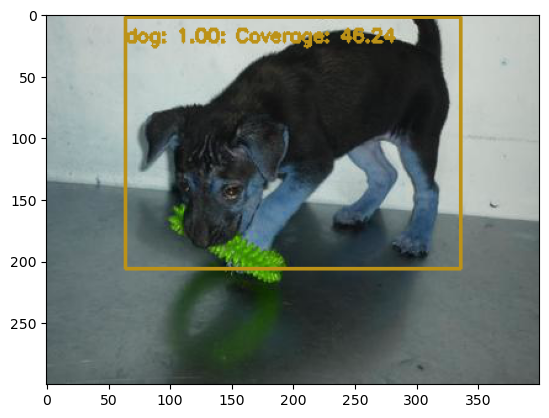

In [11]:
pyplot.imshow(image)

In [28]:
print(conf)

0.9992352724075317


In [29]:
print(cov)

46.239999999999995
